## **Step 1: Introduction**

In this mini-project, we are going to create a RNN model to classify Tweets text as either real disaster or not disaster. The data we are going to use is from Kaggle (https://www.kaggle.com/c/nlp-getting-started/overview). And this is my first time working on a NLP problem, so here I also attached my reference to get start with NLP (https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook). The goal of NLP is that gives computers abilities to interpret, manipulate and comprehend human language. 

The data we are using in this project is train.csv file. In the train.csv file, it contains 10,000 full text of tweets, the location where the tweet sent, a keyword, and with hand classified label whether it is a disaster or not. 

## **Step 2: Exploratory Data Analysis**

### 2.1. Load Libraries and Data

In [170]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Embedding, LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [100]:
df_train = pd.read_csv("../input/nlp-getting-started/train.csv")
df_test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [101]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours in...,1


In [102]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I ..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 2.2 Inspect and Visualize the Data

In [103]:
keyword_null1 = df_train['keyword'].isnull().sum()
location_null1 = df_train['location'].isnull().sum()
print("In training dataset: ")
print("Missing values in keyword column:", keyword_null1, 
     ", and its percentage in the dataset:", round(keyword_null1/len(df_train)*100, 3), "%")
print("Missing value in location column:", location_null1,
     ", and its percentage in the dataset:", round(location_null1/len(df_train)*100, 3), "%")

In training dataset: 
Missing values in keyword column: 61 , and its percentage in the dataset: 0.801 %
Missing value in location column: 2533 , and its percentage in the dataset: 33.272 %


In [104]:
keyword_null2 = df_test['keyword'].isnull().sum()
location_null2 = df_test['location'].isnull().sum()
print("In test dataset: ")
print("Missing values in keyword column:", keyword_null2, 
     ", and its percentage in the dataset:", round(keyword_null2/len(df_test)*100, 3), "%")
print("Missing value in location column:", location_null2,
     ", and its percentage in the dataset:", round(location_null2/len(df_test)*100, 3), "%")

In test dataset: 
Missing values in keyword column: 26 , and its percentage in the dataset: 0.797 %
Missing value in location column: 1105 , and its percentage in the dataset: 33.865 %


<Axes: >

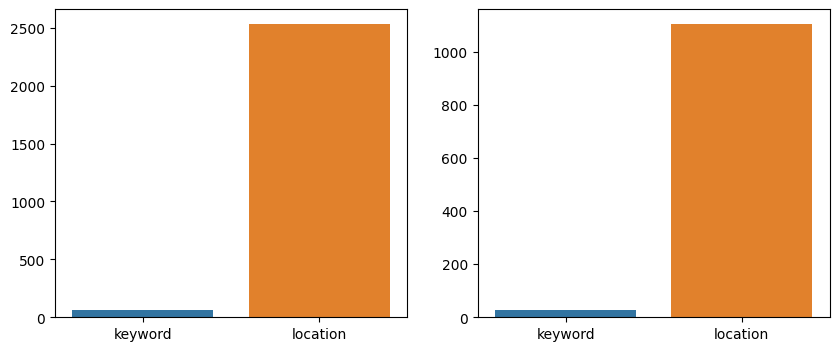

In [52]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

sns.barplot(x = ['keyword', 'location'], y = [keyword_null1, location_null1], ax = ax[0])
sns.barplot(x = ['keyword', 'location'], y = [keyword_null2, location_null2], ax = ax[1])

There are 7613 entries in the dataset, where id, text, and target are with no missing values. The data contains missing values in column keyword and location, and the percentage of missing values in "location" is up to 33%. Also, in our test set, the percentage of missing values in "location" and "keyword" are very similar as in the training set.

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

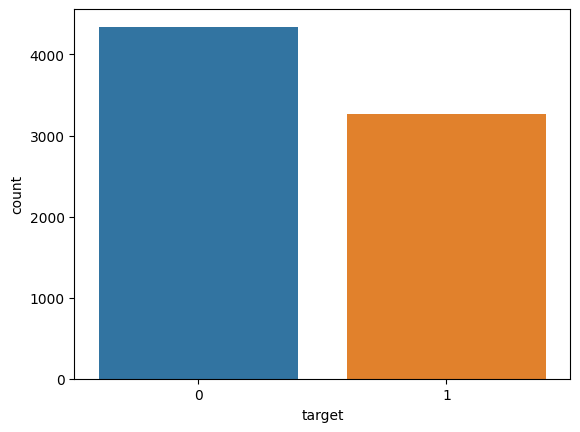

In [31]:
sns.countplot(df_train, x = "target")

df_train['target'].value_counts(normalize=True)

We can observe that about 57% of tweets in the dataset is talking about a real disaster, and 43% otherwise. They are almost equally separated so we do not need to re-balance the dataset.

Now let us check out a few text describe a real disaster and some not.

In [65]:
pd.set_option('display.max_colwidth',80)
df_train[df_train['target'] == 1]['text'].head()

0              Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                             Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No...
3                  13,000 people receive #wildfires evacuation orders in California 
4    Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours in...
Name: text, dtype: object

In [66]:
df_train[df_train['target'] == 0]['text'].head()

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object

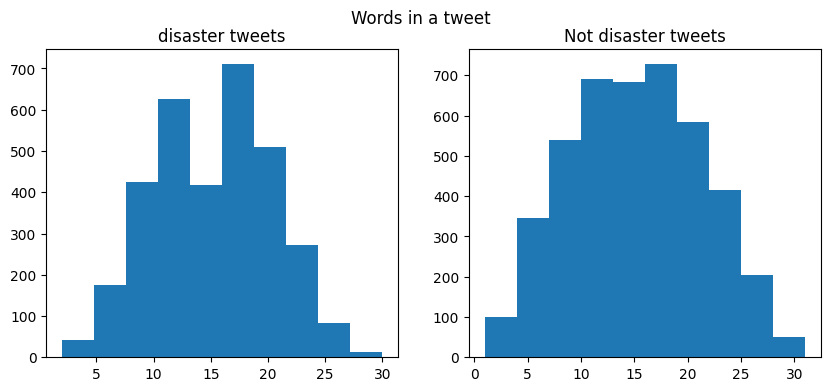

In [67]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
tweet_len = df_train[df_train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax[0].hist(tweet_len)
ax[0].set_title("disaster tweets")
tweet_len = df_train[df_train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax[1].hist(tweet_len)
ax[1].set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### 2.3. Clean Data

First of all, we are going to drop location and keyword from the dataset and focus on the full text. The location contains many missing values, and the keyword is actually a standout word in the full text of the tweet. I do not think we should weight those given keyword more than any others. 

For text preprocessing, the next step is to clean noise which are not relevant for our classification, such as punctuation, links, special characters and stopwords.

In [105]:
df_train = df_train.drop(['keyword', 'location'], axis = 1)
df_test = df_test.drop(['keyword', 'location'], axis = 1)

In [106]:
df_train

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are being notified by officers. No...,1
3,6,"13,000 people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours in...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STf...,1
7609,10870,@aria_ahrary @TheTawniest The out of control wild fires in California even i...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,Police investigating after an e-bike collided with a car in Little Portugal....,1


In [108]:
# remove urls
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(lambda x : remove_urls(x))

# remove html
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

df_train['text'] = df_train['text'].apply(lambda x : remove_html(x))

# lowercase
df_train['text'] = df_train['text'].apply(lambda x : x.lower())

# remove stopwords
stopwordlist = stopwords.words("english")
def remove_stopwords(text):
    if text is not None:
        tokens = [x for x in word_tokenize(text) if x not in stopwordlist]
        return " ".join(tokens)
    else:
        return None
        
df_train['text'] = df_train['text'].apply(lambda x : remove_stopwords(x))

# remove special characters
def remove_specialchar(text):
    table = str.maketrans('','', string.punctuation)
    return text.translate(table)

df_train['text'] = df_train['text'].apply(lambda x : remove_specialchar(x))

# remove twitter user(@users)
def remove_users(text, pat):
    table = re.findall(pat, text)
    for t in table:
        text = re.sub(i, '', text)
    return text

df_train['text'] = np.vectorize(remove_users)(df_train['text'], '@[/w]*')

# remove short words, length less than 2
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [114]:
df_train

,id,text,target
0,1,deeds reason earthquake may allah forgive,1
1,4,forest fire near ronge sask canada,1
2,5,residents asked shelter place notified officers evacuation shelter place ord...,1
3,6,13000 people receive wildfires evacuation orders california,1
4,7,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...
7608,10869,two giant cranes holding bridge collapse nearby homes,1
7609,10870,ariaahrary thetawniest control wild fires california even northern part stat...,1
7610,10871,m194 0104 utc 5km volcano hawaii,1
7611,10872,police investigating ebike collided car little portugal ebike rider suffered...,1


In [196]:
X_train = df_train['text'].values.reshape(len(df_train), )
y_train = df_train['target'].values
X_test = df_test['text'].values.reshape(len(df_test), )

In [197]:
total_tweets = np.concatenate((X_train, X_test))
print("Total tweets:", len(total_tweets))

Total tweets: 10876


In [198]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)

# get vocabulary size
voc_size = len(tokenizer.word_index) + 1
# max length for padding
max_len = max(len(x.split()) for x in total_tweets)

In [199]:
token_train = tokenizer.texts_to_sequences(X_train)
token_test = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(token_train, maxlen = max_len, padding = 'post')
pad_test = pad_sequences(token_test, maxlen = max_len, padding = 'post')

## **Step 3: Create Models**

First, we are going to create a simple RNN model and check the performance.

### Simple RNN model

In [204]:
model = Sequential()

model.add(Embedding(voc_size, 100, input_length = max_len))
model.add(SimpleRNN(128))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 31, 100)           2461400   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               29312     
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,523,993
Trainable params: 2,523,993
N

In [205]:
# Compile
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [206]:
# model fit
hist = model.fit(pad_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.2)

Epoch 1/10
191/191 [==============================] - 7s 26ms/step - loss: 0.6227 - accuracy: 0.6483 - val_loss: 0.6067 - val_accuracy: 0.6697
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.4182 - accuracy: 0.8232 - val_loss: 0.5608 - val_accuracy: 0.7183
Epoch 3/10
191/191 [==============================] - 5s 25ms/step - loss: 0.2666 - accuracy: 0.9020 - val_loss: 0.5909 - val_accuracy: 0.7308
Epoch 4/10
191/191 [==============================] - 5s 26ms/step - loss: 0.1828 - accuracy: 0.9376 - val_loss: 0.7728 - val_accuracy: 0.6993
Epoch 5/10
191/191 [==============================] - 5s 27ms/step - loss: 0.1307 - accuracy: 0.9603 - val_loss: 0.7596 - val_accuracy: 0.7104
Epoch 6/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0991 - accuracy: 0.9704 - val_loss: 0.7829 - val_accuracy: 0.7058
Epoch 7/10
191/191 [==============================] - 5s 26ms/step - loss: 0.0850 - accuracy: 0.9719 - val_loss: 0.8941 - val_accuracy: 0.7019

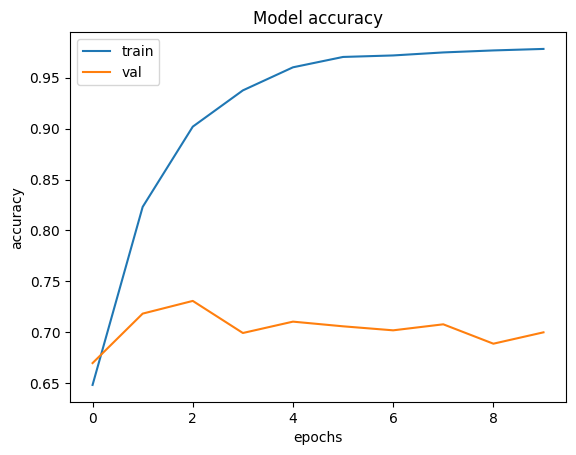

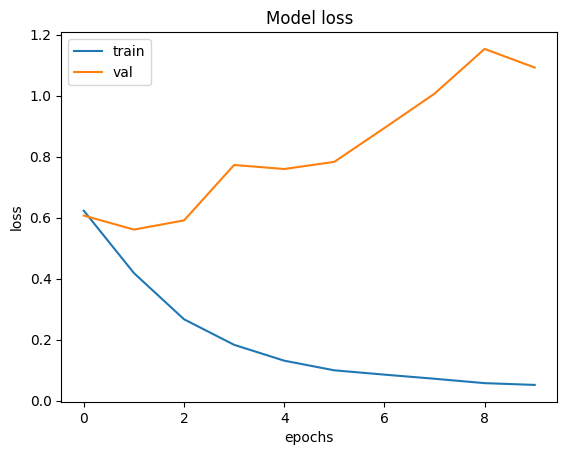

In [207]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Our first model looks overfit, as the training accuracy reached 0.97, the validation accuracy was only 0.7.Also, when the training loss went down, the validation loss was actually went up. Now let us try some other model.

### LSTM model

In [208]:
model = Sequential()

model.add(Embedding(voc_size, 100, input_length = max_len))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.5))
    
model.add(Bidirectional(LSTM(32, return_sequences = False)))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
    
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 31, 100)           2461400   
                                                                 
 bidirectional_6 (Bidirectio  (None, 31, 256)          234496    
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 31, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 31, 128)          164352    
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 31, 128)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)             

In [209]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [210]:
hist = model.fit(pad_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.2, shuffle = True)

Epoch 1/10
191/191 [==============================] - 38s 143ms/step - loss: 0.6820 - accuracy: 0.5742 - val_loss: 0.6864 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 25s 132ms/step - loss: 0.5703 - accuracy: 0.7113 - val_loss: 0.5124 - val_accuracy: 0.7597
Epoch 3/10
191/191 [==============================] - 26s 135ms/step - loss: 0.3432 - accuracy: 0.8703 - val_loss: 0.5089 - val_accuracy: 0.7433
Epoch 4/10
191/191 [==============================] - 25s 134ms/step - loss: 0.2298 - accuracy: 0.9207 - val_loss: 0.5691 - val_accuracy: 0.7590
Epoch 5/10
191/191 [==============================] - 25s 132ms/step - loss: 0.1560 - accuracy: 0.9488 - val_loss: 0.5882 - val_accuracy: 0.7564
Epoch 6/10
191/191 [==============================] - 25s 133ms/step - loss: 0.1099 - accuracy: 0.9658 - val_loss: 0.8714 - val_accuracy: 0.7157
Epoch 7/10
191/191 [==============================] - 25s 133ms/step - loss: 0.0889 - accuracy: 0.9726 - val_loss: 0.8560 - val_ac

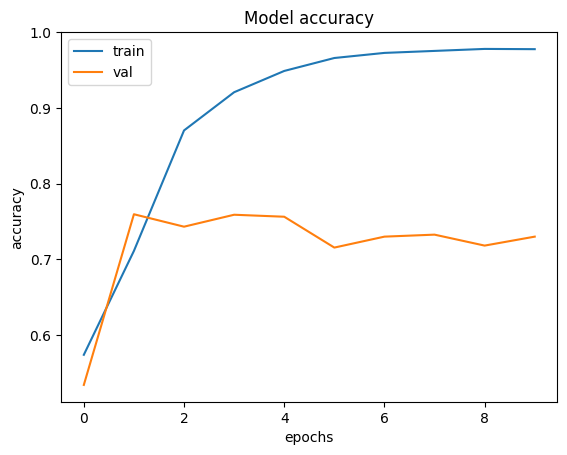

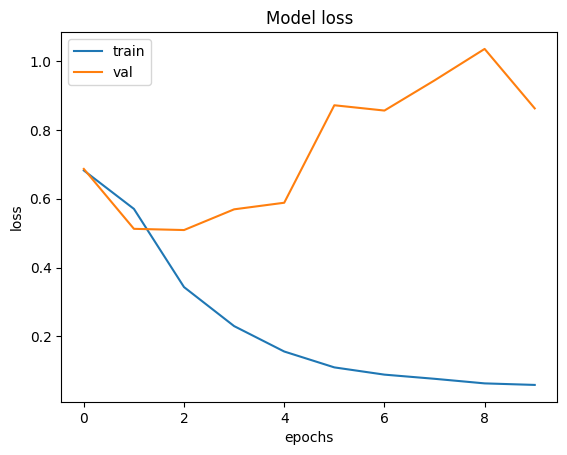

In [211]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Our second model has improved but 75% accuracy is not great, and it actually still overfitting. So I am also going to reduce my epochs to 5 instead.**

### Bidirectional LSTM Model

In [220]:
model = Sequential()
model.add(Embedding(voc_size, 100, input_length = max_len))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 31, 100)           2461400   
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dense_29 (Dense)            (None, 64)                16448     
                                                                 
 dense_30 (Dense)            (None, 16)                1040      
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,713,401
Trainable params: 2,713,401
Non-trainable params: 0
___________________________________________

In [221]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [222]:
hist = model.fit(pad_train, y_train, batch_size = 16, epochs = 5, validation_split = 0.2, shuffle = True)

Epoch 1/5
381/381 [==============================] - 23s 50ms/step - loss: 0.6678 - accuracy: 0.5931 - val_loss: 0.6304 - val_accuracy: 0.6875
Epoch 2/5
381/381 [==============================] - 19s 49ms/step - loss: 0.4597 - accuracy: 0.7975 - val_loss: 0.4582 - val_accuracy: 0.7958
Epoch 3/5
381/381 [==============================] - 18s 48ms/step - loss: 0.2955 - accuracy: 0.8803 - val_loss: 0.4616 - val_accuracy: 0.7886
Epoch 4/5
381/381 [==============================] - 19s 49ms/step - loss: 0.2170 - accuracy: 0.9186 - val_loss: 0.5180 - val_accuracy: 0.7945
Epoch 5/5
381/381 [==============================] - 18s 48ms/step - loss: 0.1567 - accuracy: 0.9438 - val_loss: 0.5687 - val_accuracy: 0.7708


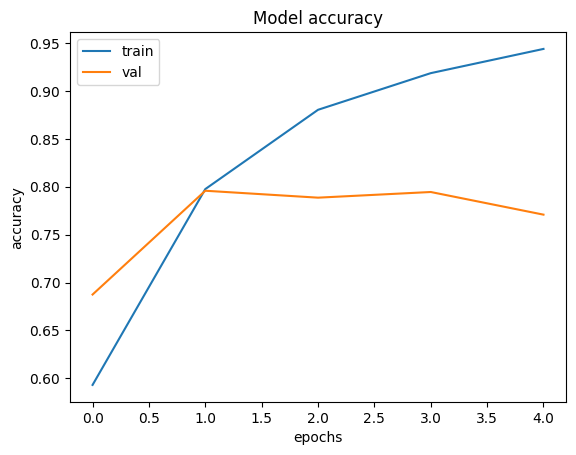

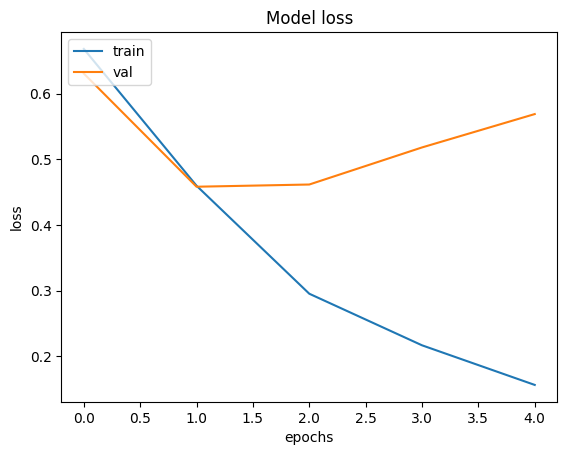

In [223]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**However, my best validation accuracy was 0.796 only, which is barely better than my first two models.**

### Prediction (sample submission)

In [225]:
pred = model.predict(pad_test)

102/102 [==============================] - 3s 18ms/step


In [226]:
df_test['target'] = pred
df_test['target'] = df_test['target'].apply(lambda x : 0 if x<=0.5 else 1)

In [234]:
df_test

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [235]:
df_test.to_csv("submission.csv", index = False)

## **Conclusion**

In this project, I created three models, which are a simple RNN, a LSTM and a bidirectional LSTM model to classify tweets as "disaster" or "not disaster". First of all, when we are cleaning the dataset, we have done a lot of word cleaning work. For example, in tweets, there are many @users in the full texts, so I decided to remove those @users to avoid some noises. Also, we also removed some other words or special characters that are not relevant to our classification.

Actually all three models did not perform well, the best accuracy among all was almost 80% only. But it is my first time to learn how to use NLP techniques, and I learned a lot in this project, such as how to work with NLP tools in Keras, and how to build a RNN model. Hopefully I can use these knowledges in the future. 
